**Setup for visualizers**

The notebook loads a cohort of patients with mutations in *PTPN11*, performs the functional variant annotation, and collates the data into a `Cohort` object.

In [1]:
%matplotlib inline

import os
import hpotk

hpotk.util.setup_logging()

# Setup resources

Set up paths to resources that work on the system. 

We need just the path to the local copy of the *phenopacket-store* repo.

In [2]:
fpath_phenopacket_store = '../../phenopacket-store'

fpath_ptpn11 = os.path.join(fpath_phenopacket_store, 'notebooks', 'PTPN11', 'phenopackets')
assert os.path.isdir(fpath_ptpn11), 'Update path to folder with PTPN11 phenopackets'

## Load HPO

Use HPO release *2023-10-09*. The ontology is downloaded from the PURL.

In [3]:
import hpotk

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

fpath_hpo = 'https://github.com/obophenotype/human-phenotype-ontology/releases/download/v2023-10-09/hp.json'

hpo = hpotk.load_minimal_ontology(fpath_hpo)
hpo.version

'2023-10-09'

# Load samples

## Configure patient creator

Patient creator transforms phenopackets into `Patient`s - the internal representation of the sample data. 

The transformation includes checking that the phenotypic features -  the uses HPO to check all phenotypic features are annotated with current HPO terms 

### Setup phenotypic feature validation

We ensure that the phenotypic features of the subjects meet the following validation requirements:
- the phenotypic features are represented using current (non-obsolete) HPO term IDs
- all phenotypic features are descendants of *Phenotypic abnormality* branch of HPO
- the terms do not violate the annotation propagation rule - subjects are not annotated by a term and its ancestor/descendant

In [4]:
from hpotk.validate import ValidationRunner
from hpotk.validate import ObsoleteTermIdsValidator, PhenotypicAbnormalityValidator, AnnotationPropagationValidator

validation_runner = ValidationRunner(
    validators=(
        ObsoleteTermIdsValidator(hpo),
        PhenotypicAbnormalityValidator(hpo),
        AnnotationPropagationValidator(hpo)
        ))

In [5]:
from genophenocorr.preprocessing import configure_caching_patient_creator

patient_creator = configure_caching_patient_creator(hpo, validation_runner=validation_runner)

## Load phenopackets

Walk the directory, find all JSON files, load them into phenopackets, and transform the phenopackets to patients.

In [6]:
from phenopackets import Phenopacket
from google.protobuf.json_format import Parse

samples = []
for dirpath, dirnames, filenames in os.walk(fpath_ptpn11):
    for filename in filenames:
        if filename.endswith('.json'):
            fpath_pp = os.path.join(dirpath, filename)
            pp = Phenopacket()
            with open(fpath_pp) as fh:
                Parse(fh.read(), pp)
            patient = patient_creator.create_patient(pp)
            samples.append(patient)

f'Loaded {len(samples)} samples'

'Loaded 42 samples'

## Gather samples into cohort

Gather the samples and calculate the cohort summary statistics such as transcripts affected by the variants.

In [7]:
from genophenocorr.model import Cohort

cohort = Cohort.from_patients(samples)
cohort.all_transcripts

{'NM_001330437.2', 'NM_001374625.1', 'NM_002834.5', 'NM_080601.3'}

# Gather data for visualization

Here we get the data required for visualizing the variants on selected transcript or protein.

## Choose the transcript

We need to choose the transcript and protein IDs - currently this is done manually but we will find a way how to do this automatically, e.g. using MANE transcript.

The MANE transcript for *PTPN11* is [NM_002834.5](https://www.genenames.org/data/gene-symbol-report/#!/hgnc_id/HGNC:9644).

In [8]:
tx_id = 'NM_002834.5'
protein_id = 'NP_002825.3'

## Gather the data for visualization

We need to get:
- variants
- transcript coordinates
- protein metadata

### Variants

Variants are easy, `Cohort` exposes all the variants via the `all_variants` property:

In [9]:
variants = cohort.all_variants
len(variants)

42

In [10]:
next(iter(variants))

Variant(variant_coordinates:VariantCoordinates(region=GenomicRegion(contig=12, start=112453273, end=112453274, strand=+), ref=C, alt=T, change_length=1), tx_annotations:(TranscriptAnnotation(gene_id:PTPN11,transcript_id:NM_001330437.2,hgvsc_id:NM_001330437.2:c.412C>T,is_preferred:False,variant_effects:(<VariantEffect.STOP_GAINED: 'SO:0001587'>,),overlapping_exons:(4,),protein_affected:(ProteinMetadata(id=NP_001317366.1, label=Tyrosine-protein phosphatase non-receptor type 11, features=(SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=SH2 1, start=6, end=102)), SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=SH2 2, start=112, end=216)), SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=Tyrosine-protein phosphatase, start=247, end=517)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Disordered, start=548, end=571)))),),protein_effect_location:Region(start=137, end=138)), TranscriptAnnotation(gene_id:PTPN11,tra

### Transcript coordinates

Transcript coordinates can be fetched from Variant Validator API:

In [11]:
from genophenocorr.model.genome import GRCh38
from genophenocorr.preprocessing import VVTranscriptCoordinateService

txc_service = VVTranscriptCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(tx_id)
tx_coordinates

TranscriptCoordinates(identifier=NM_002834.5, region=GenomicRegion(contig=12, start=112418946, end=112509918, strand=+))

The `TranscriptCoordinates` object knows about the number of coding bases and aminoacid codons. 

Note, the counts of coding bases and codons do *not* include the termination codon.

In [12]:
print(f'{tx_id} has {tx_coordinates.get_coding_base_count():,} coding bases')
print(f'{tx_id} has {tx_coordinates.get_codon_count():,} codons')

NM_002834.5 has 1,779 coding bases
NM_002834.5 has 593 codons


We can get the UTR regions (both 5' and 3') as well as the CDS regions.

Note, for simplicity, the CDS regions include *both* initiation and termination codons!

5' UTR regions:

In [13]:
for utr in tx_coordinates.get_five_prime_utrs():
    print(f'{utr.start:,}-{utr.end:,}')

112,418,946-112,419,111


CDS regions:

In [14]:
for cds in tx_coordinates.get_cds_regions():
    print(f'{cds.start:,}-{cds.end:,}')

112,419,111-112,419,125
112,446,275-112,446,398
112,450,317-112,450,512
112,453,194-112,453,387
112,454,563-112,454,680
112,455,949-112,456,063
112,472,943-112,473,040
112,477,650-112,477,730
112,477,856-112,478,015
112,482,073-112,482,205
112,486,474-112,486,629
112,488,442-112,488,510
112,489,023-112,489,175
112,502,143-112,502,256
112,504,694-112,504,764


3' UTR regions

In [15]:
for utr in tx_coordinates.get_three_prime_utrs():
    print(f'{utr.start:,}-{utr.end:,}')

112,504,764-112,504,796
112,505,824-112,509,918


### Protein metadata

Last, we fetch the protein metadata from Uniprot.

The significance of the warning that is logged is unclear to me at this time. We need to investigate.

In [16]:
from genophenocorr.preprocessing import UniprotProteinMetadataService

pms = UniprotProteinMetadataService()

protein_metas = pms.annotate(protein_id)

assert len(protein_metas) == 1
protein_meta = protein_metas[0]
protein_meta

2023-12-12 14:53:08,278 genophenocorr.preprocessing._uniprot WARNING : UniProt did not return a protein ID that matches the ID we searched for: NP_002825.3 not in ['NP_001308315.1', 'NP_001308316.1', 'NP_002816.1']
2023-12-12 14:53:08,279 genophenocorr.preprocessing._uniprot WARNING : UniProt did not return a protein ID that matches the ID we searched for: NP_002825.3 not in ['NP_001172004.1', 'NP_001172005.1', 'NP_001172010.1', 'NP_001172011.1', 'NP_002015.1']
2023-12-12 14:53:08,279 genophenocorr.preprocessing._uniprot WARNING : UniProt did not return a protein ID that matches the ID we searched for: NP_002825.3 not in ['NP_000508.1', 'NP_000549.1']


ProteinMetadata(id=NP_002825.3, label=Tyrosine-protein phosphatase non-receptor type 11, features=(SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=SH2 1, start=6, end=102)), SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=SH2 2, start=112, end=216)), SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=Tyrosine-protein phosphatase, start=247, end=517)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Disordered, start=548, end=571))))

We get metadata with 4 features (3 domains and 1 region), which is in line with the Uniprot [Family & Domains section](https://www.uniprot.org/uniprotkb/Q06124/entry#family_and_domains).

In [17]:
for feature in protein_meta.protein_features:
    print(f'name: {feature.info.name}, type: {feature.feature_type}, start: {feature.info.start}, end: {feature.info.end}, ')

name: SH2 1, type: FeatureType.DOMAIN, start: 6, end: 102, 
name: SH2 2, type: FeatureType.DOMAIN, start: 112, end: 216, 
name: Tyrosine-protein phosphatase, type: FeatureType.DOMAIN, start: 247, end: 517, 
name: Disordered, type: FeatureType.REGION, start: 548, end: 571, 


# Visualize the data

### Draw the figures

Now, let's draw the plots:

In [18]:
from genophenocorr.view import VariantTranscriptVisualizer

artist = VariantTranscriptVisualizer(transcript='NM_002834.5')

### TODO - implement

{Variant(variant_coordinates:VariantCoordinates(region=GenomicRegion(contig=12, start=112453273, end=112453274, strand=+), ref=C, alt=T, change_length=1), tx_annotations:(TranscriptAnnotation(gene_id:PTPN11,transcript_id:NM_001330437.2,hgvsc_id:NM_001330437.2:c.412C>T,is_preferred:False,variant_effects:(<VariantEffect.STOP_GAINED: 'SO:0001587'>,),overlapping_exons:(4,),protein_affected:(ProteinMetadata(id=NP_001317366.1, label=Tyrosine-protein phosphatase non-receptor type 11, features=(SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=SH2 1, start=6, end=102)), SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=SH2 2, start=112, end=216)), SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=Tyrosine-protein phosphatase, start=247, end=517)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Disordered, start=548, end=571)))),),protein_effect_location:Region(start=137, end=138)), TranscriptAnnotation(gene_id:PTPN11,tr

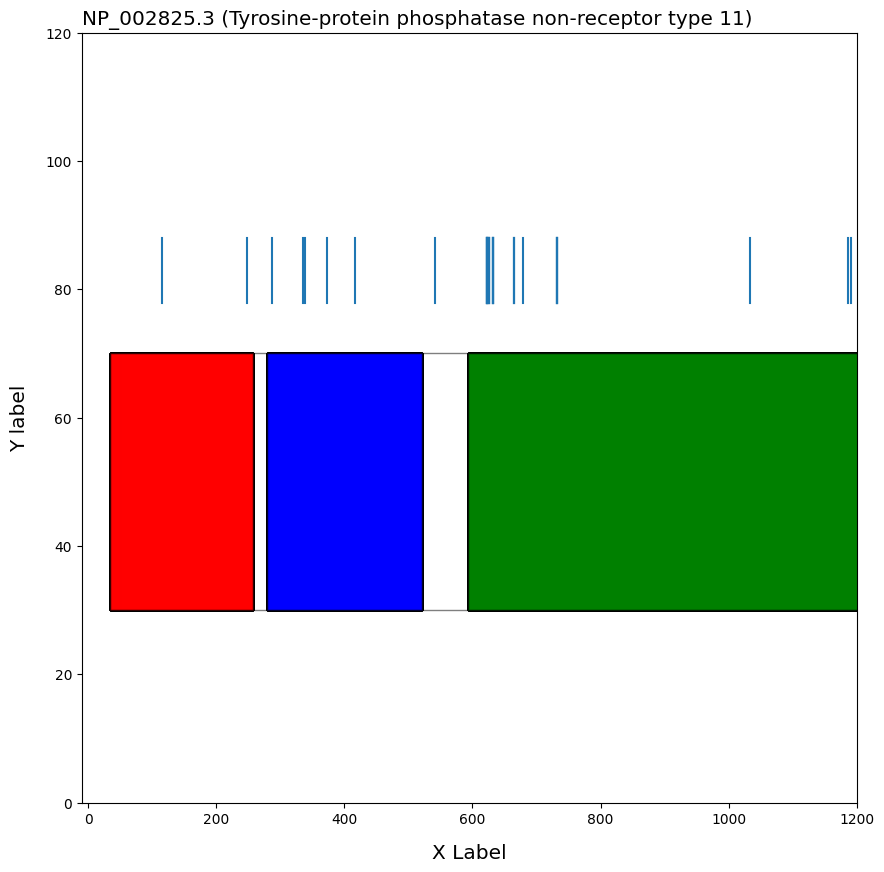

In [19]:
artist.draw_variants(variants, tx_coordinates, protein_meta)

In [20]:
v = next(iter(variants))

In [21]:
txa = v.tx_annotations[0]
print(txa.protein_affected)

(ProteinMetadata(id=NP_001317366.1, label=Tyrosine-protein phosphatase non-receptor type 11, features=(SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=SH2 1, start=6, end=102)), SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=SH2 2, start=112, end=216)), SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=Tyrosine-protein phosphatase, start=247, end=517)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Disordered, start=548, end=571)))),)


In [22]:
for p in txa.protein_affected:
    for f in p.domains():
        print(f.info)

FeatureInfo(name=SH2 1, start=6, end=102)
FeatureInfo(name=SH2 2, start=112, end=216)
FeatureInfo(name=Tyrosine-protein phosphatase, start=247, end=517)
